In [1]:
import cv2    # 加载OpenCV
import matplotlib.pyplot as plt   # 加载Matplotlib.pyplot存进plt
# from pan_pp_descmask import random_rot_flip
import mmcv
import numpy as np
img_path = '/share/lizhuang05/datasets/DB/annos_5w/train_images/1/36324147276_h.jpg'


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [2]:
import mmcv
def get_ann_ic15(img, gt_path):
    # h, w = img.shape[0:2]
    lines = mmcv.list_from_file(gt_path)
    bboxes = []
    words = []
    for line in lines:
        line = line.encode('utf-8').decode('utf-8-sig')
        line = line.replace('\xef\xbb\xbf', '')
        gt = line.split('\t')
        word = gt[8].replace('\r', '').replace('\n', '')
        if len(word) == 0 or word[0] == '#':
            words.append('###')
        else:
            words.append(word)

        bbox = [int(float(gt[i])) for i in range(8)]
        # bbox = np.array(bbox) / ([w * 1.0, h * 1.0] * 4)
        bboxes.append(bbox)
    return np.array(bboxes), words

def is_ver_word(bbox):
    x1, y1, x2, y2, x3, y3, x4, y4 = bbox
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    h = y_max - y_min
    w = x_max - x_min
    if h > w * 1.5:
        return True
    else:
        return False

def random_rot_flip(img, bboxes, words, mode):
    assert mode in [0,1,2,3,4,5]
    if mode == 0: 
        # 竖直flip模式
        dealed_img = cv2.flip(img, 0).copy()
        h, w = dealed_img.shape[0:2]
        # bbox y 对称
        bboxes = [[bbox[0], h-bbox[1], bbox[2], h-bbox[3], bbox[4], h-bbox[5], bbox[6], h-bbox[7]] for bbox in bboxes]
        for i, word in enumerate(words):
            if is_ver_word(bboxes[i]):
                words[i] = word[::-1]

    elif mode == 1:
        # 水平flip
        dealed_img = cv2.flip(img, 1).copy()
        h, w = dealed_img.shape[0:2]
        # bbox y 对称
        bboxes = [[w-bbox[0], bbox[1], w-bbox[2], bbox[3], w-bbox[4], bbox[5], w-bbox[6], bbox[7]] for bbox in bboxes]
        for i, word in enumerate(words):
            if not is_ver_word(bboxes[i]):
                words[i] = word[::-1]
    
    elif mode == 2:
        ori_h, ori_w = img.shape[0:2]
        # 旋转90
        dealed_img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
        h, w = dealed_img.shape[0:2]
        bboxes = [[
                    w-bbox[1]/ori_h*w, bbox[0]/ori_w * h,
                    w-bbox[3]/ori_h*w, bbox[2]/ori_w * h, 
                    w-bbox[5]/ori_h*w, bbox[4]/ori_w * h, 
                    w-bbox[7]/ori_h*w, bbox[6]/ori_w * h] for bbox in bboxes]
        for i, word in enumerate(words):
            if not is_ver_word(bboxes[i]):  #如果是横排，原来是竖排，阅读顺序反序
                words[i] = word[::-1]

    elif mode == 3:
        # 旋转180
        h, w = img.shape[0:2]
        # 旋转90
        dealed_img = cv2.rotate(img, cv2.cv2.ROTATE_180) 
        bboxes = [[w-bbox[0], h-bbox[1], w-bbox[2], h-bbox[3], w-bbox[4], h-bbox[5], w-bbox[6], h-bbox[7]] for bbox in bboxes]
        for i, word in enumerate(words):
            # 无论横竖都要反序
            words[i] = word[::-1]

    elif mode == 4:
        # 旋转270
        ori_h, ori_w = img.shape[0:2]
        dealed_img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE) 
        h, w = dealed_img.shape[0:2]
        bboxes = [[
                    bbox[1]/ori_h*w, h - bbox[0]/ori_w * h,
                    bbox[3]/ori_h*w, h - bbox[2]/ori_w * h, 
                    bbox[5]/ori_h*w, h - bbox[4]/ori_w * h, 
                    bbox[7]/ori_h*w, h - bbox[6]/ori_w * h] for bbox in bboxes]
        for i, word in enumerate(words):
            if is_ver_word(bboxes[i]):  #如果是横排，原来是竖排，阅读顺序反序
                words[i] = word[::-1]
    else:
        raise "Not a valida mode: {}!".format(mode)
        
    return dealed_img,  bboxes, words

def get_img(img_path, read_type='cv2'):
    try:
        if read_type == 'cv2':
            img = cv2.imread(img_path)
            img = img[:, :, [2, 1, 0]]
        elif read_type == 'pil':
            img = np.array(Image.open(img_path))
    except Exception as e:
        print(img_path)
        raise
    return img

['###', '三十而已', '美好']
[[ 19 424 179 424 179 452  19 452]
 [ 33 461 179 461 179 499  33 499]
 [288  48 319  48 319 123 288 123]]


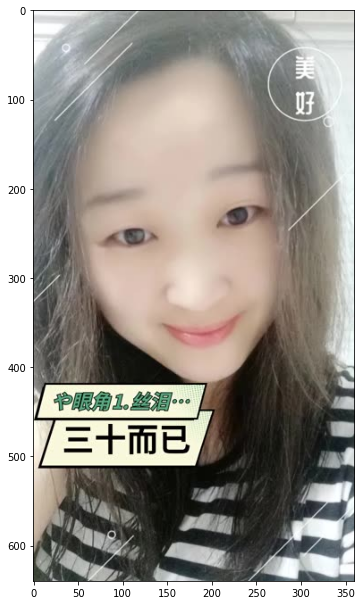

In [16]:
import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

img_path = '/share/lizhuang05/datasets/DB/annos_5w/train_images/1/36323922381_h.jpg'
gt_path = '/share/lizhuang05/datasets/DB/annos_5w/train_gts_withrec/1/36323922381_h.txt'
img = get_img(img_path, 'cv2')
bboxes, words = get_ann_ic15(img, gt_path)
print(words)
print(bboxes)
plt.imshow(img)

['###', '已而十三', '美好']
[[424.0, 341.0, 424.0, 181.0, 452.0, 181.0, 452.0, 341.0], [461.0, 327.0, 461.0, 181.0, 499.0, 181.0, 499.0, 327.0], [48.0, 72.0, 48.0, 41.0, 123.0, 41.0, 123.0, 72.0]]


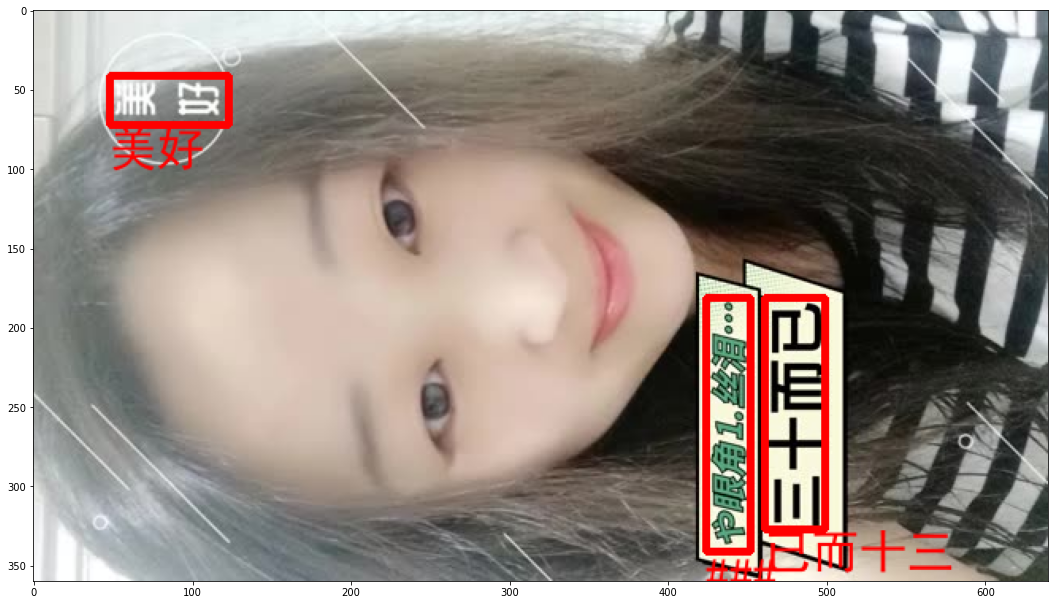

In [17]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
new_img, new_bboxes, new_words = random_rot_flip(img, bboxes, words,mode=4)
print(new_words)
print(new_bboxes)

plot_img = plot_tracking(new_img, new_bboxes, words)
plt.imshow(plot_img)

In [11]:
from PIL import Image, ImageFont, ImageDraw

def paint_chinese_opencv(im, chinese, pos, color, font_size=35):
    img_PIL = Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    font = ImageFont.truetype('/home/lizhuang05/code/video_ocr/video_tools/simhei.ttf', int(font_size))
    fillColor = color[::-1]  #  (255,0,0)
    position = pos #  (100,100)
    # if not isinstance(chinese, unicode):
    #     chinese = chinese.decode('utf-8')
    draw = ImageDraw.Draw(img_PIL, mode='RGB')
    draw.text(position, chinese, font=font, fill=fillColor)

    img = cv2.cvtColor(np.asarray(img_PIL), cv2.COLOR_RGB2BGR)
    return img
def plot_tracking(image, points, content_list, frame_id=0, keyword=""):
    color_table = {"FP": (255, 0, 0), "FN": (0, 0, 255), "TP": (0, 255, 0), "IGNORE": (192, 192, 192)}
    
    im = np.ascontiguousarray(np.copy(image))
    im_h, im_w = im.shape[:2]

    text_scale = max(3, max(image.shape[1], image.shape[0]) / 1600.)
    line_thickness = 3 * int(max(image.shape[1], image.shape[0]) / 500.)
    radius = max(5, int(im_w/140.))
#     cv2.putText(im, 'frame: %s ' % (str(frame_id)),
#                 (0, int(15 * text_scale)), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255), thickness=2)

    for i, point in enumerate(points):
        x1, y1,x2, y2, x3, y3, x4, y4 = point
        intbox = list(map(lambda x: int(float(x)), (x1, y1, x2, y2, x3, y3, x4, y4)))
        intbox_np = np.array(intbox).reshape(-1,1,2)
        content = content_list[i]
        id_text = content
        # 画四边形
        cv2.polylines(im, [intbox_np], True, color=color_table['FP'], thickness=line_thickness)
        id_pos = intbox_np[0]
  
        im = paint_chinese_opencv(im, id_text, tuple(id_pos[0]), color_table['FP'], font_size=text_scale*10)

    return im